<a href="https://colab.research.google.com/github/dwdb/tensorflow2.0-tutorial/blob/master/text/Text%20classification%20with%20an%20RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## Setup input pipeline
The IMDB large movie review dataset is a binary classification dataset—all the reviews have either a positive or negative sentiment.

In [7]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_examples, test_examples = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteBF1ZU2/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteBF1ZU2/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteBF1ZU2/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [11]:
encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [13]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

assert original_string == sample_string

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [17]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## prepare_the_data_for_training


In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [0]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE, padded_shapes=([None],[])))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE,  padded_shapes=([None],[])))

In [0]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE))

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [0]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [40]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 44s 112ms/step - loss: 0.6702 - accuracy: 0.5236 - val_loss: 0.5555 - val_accuracy: 0.6203
Epoch 2/10
391/391 [==============================] - 44s 113ms/step - loss: 0.3648 - accuracy: 0.8399 - val_loss: 0.3649 - val_accuracy: 0.8578
Epoch 3/10
391/391 [==============================] - 44s 113ms/step - loss: 0.2485 - accuracy: 0.9027 - val_loss: 0.3361 - val_accuracy: 0.8724
Epoch 4/10
391/391 [==============================] - 44s 113ms/step - loss: 0.2101 - accuracy: 0.9215 - val_loss: 0.3666 - val_accuracy: 0.8568
Epoch 5/10
391/391 [==============================] - 44s 112ms/step - loss: 0.1793 - accuracy: 0.9349 - val_loss: 0.3510 - val_accuracy: 0.8724
Epoch 6/10
391/391 [==============================] - 44s 114ms/step - loss: 0.1707 - accuracy: 0.9388 - val_loss: 0.4303 - val_accuracy: 0.8661
Epoch 7/10
391/391 [==============================] - 44s 113ms/step - loss: 0.1444 - accuracy: 0.9492 - val_loss: 0.4228 - val_ac

In [41]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 16s 42ms/step - loss: 0.5148 - accuracy: 0.8405
Test Loss: 0.5148305296897888
Test Accuracy: 0.8405200242996216


In [0]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [0]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [44]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.01354332]]


In [45]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-0.15596758]]


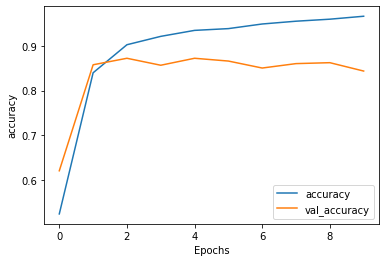

In [46]:
plot_graphs(history, 'accuracy')

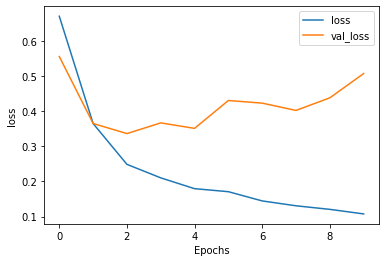

In [47]:
plot_graphs(history, 'loss')

## Stack two or more LSTM layers

In [0]:
# return_sequence=Fasle，返回最后一个单个hidden_state
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [0]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [59]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 77s 197ms/step - loss: 0.6905 - accuracy: 0.5001 - val_loss: 0.6730 - val_accuracy: 0.4917
Epoch 2/10
391/391 [==============================] - 76s 193ms/step - loss: 0.4413 - accuracy: 0.7874 - val_loss: 0.3906 - val_accuracy: 0.8422
Epoch 3/10
391/391 [==============================] - 76s 193ms/step - loss: 0.2863 - accuracy: 0.8897 - val_loss: 0.3652 - val_accuracy: 0.8651
Epoch 4/10
391/391 [==============================] - 76s 194ms/step - loss: 0.2273 - accuracy: 0.9194 - val_loss: 0.3714 - val_accuracy: 0.8573
Epoch 5/10
391/391 [==============================] - 75s 193ms/step - loss: 0.1973 - accuracy: 0.9320 - val_loss: 0.3694 - val_accuracy: 0.8698
Epoch 6/10
391/391 [==============================] - 76s 195ms/step - loss: 0.1717 - accuracy: 0.9430 - val_loss: 0.4444 - val_accuracy: 0.8661
Epoch 7/10
391/391 [==============================] - 76s 195ms/step - loss: 0.1512 - accuracy: 0.9507 - val_loss: 0.4779 - val_ac

In [60]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 31s 80ms/step - loss: 0.4991 - accuracy: 0.8346
Test Loss: 0.49907854199409485
Test Accuracy: 0.8346400260925293


In [61]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-3.537562]]


In [62]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-3.7720418]]


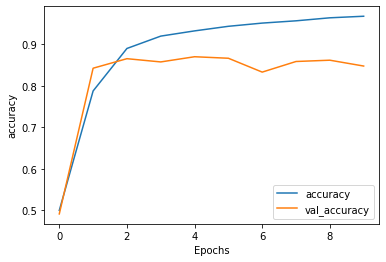

In [63]:
plot_graphs(history, 'accuracy')

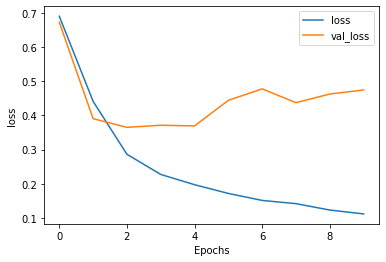

In [64]:
plot_graphs(history, 'loss')